In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier

ongevallen_priv = pd.read_csv("ongevallen.txt")
ongevallen_pub = pd.read_csv("ongevallen_open.txt")
merged_data = pd.merge(ongevallen_priv, ongevallen_pub, on='VKL_NUMMER')

xls = pd.ExcelFile('feature_engineering.xlsx')

df_inhabit = pd.read_excel(xls, 'INHABIT')
df_caruse = pd.read_excel(xls, 'CARUSE')

merged_df = pd.merge(merged_data, df_inhabit, on='GME_NAAM', how='left')
merged_df = pd.merge(merged_df, df_caruse, on='GME_NAAM', how='left')

selected_columns = ['DAG_CODE_x', 'MND_NUMMER_x', 'UUR_x', 'GME_NAAM', 'PVE_NAAM',
                    'INHABITANTS', 'CARUSE',
                    'MNE_CODE_x', 'ANTL_PTJ', 'AOL_ID',
                    'WSE_ID', 'BEBKOM', 'MAXSNELHD', 
                    'WVL_ID', 'WVG_ID', 'WDK_ID','LGD_ID', 
                    'ZAD_ID','WGD_CODE_1','BZD_ID_VM1',
                    'BZD_ID_IF1','BZD_ID_TA1', 'IND_ALC', 'ANTL_SLA_x', 
                    'ANTL_GZH_x','ANTL_SEH_x','ANTL_DOD_x',]

selected_factors = merged_df[selected_columns]

selected_factors['AOL_ID'] = selected_factors['AOL_ID'].replace(0, pd.NA)
selected_factors = selected_factors.drop(['ZAD_ID','BZD_ID_VM1','BZD_ID_IF1','BZD_ID_TA1','IND_ALC'], axis=1)
selected_factors['UUR_x'] = selected_factors['UUR_x'].fillna(selected_factors['UUR_x'].mean())

variables_missing_values = ['WSE_ID', 'BEBKOM', 'MAXSNELHD', 'WVL_ID', 'WVG_ID', 'WDK_ID', 'LGD_ID', 'WGD_CODE_1', 'AOL_ID','INHABITANTS', 'CARUSE']

for column in variables_missing_values:
    most_frequent_value = selected_factors[column].mode()[0]
    selected_factors[column].fillna(most_frequent_value, inplace=True)
    
selected_factors[['VICTIMS', 'INJURED', 'BADLY_INJURED', 'DEATHS']] = selected_factors[['ANTL_SLA_x', 'ANTL_GZH_x', 'ANTL_SEH_x', 'ANTL_DOD_x']].apply(lambda x: (x != 0).astype(int))

intermediate = selected_factors.drop(['ANTL_SLA_x', 'ANTL_GZH_x', 'ANTL_SEH_x', 'ANTL_DOD_x'], axis=1)

final = intermediate.copy()

categorical_cols = ['DAG_CODE_x', 'UUR_x', 'GME_NAAM', 'PVE_NAAM', 
                    'MNE_CODE_x', 'AOL_ID', 
                    'WSE_ID', 'BEBKOM', 'MAXSNELHD', 'WVL_ID', 
                    'WVG_ID', 'WDK_ID', 'LGD_ID', 'WGD_CODE_1', 'ANTL_PTJ']

label_encoder = LabelEncoder()
for col in categorical_cols:
    final[col] = label_encoder.fit_transform(final[col].astype(str))

final.head(5)

C:\Users\rami1\AppData\Local\Temp\ipykernel_15980\1893030484.py:15: DtypeWarning: Columns (1,2,24,25,29,31,35,39,43,47,52,64) have mixed types. Specify dtype option on import or set low_memory=False.
  ongevallen_pub = pd.read_csv("ongevallen_open.txt")
C:\Users\rami1\AppData\Local\Temp\ipykernel_15980\1893030484.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_factors['AOL_ID'] = selected_factors['AOL_ID'].replace(0, pd.NA)


,DAG_CODE_x,MND_NUMMER_x,UUR_x,GME_NAAM,PVE_NAAM,INHABITANTS,CARUSE,MNE_CODE_x,ANTL_PTJ,AOL_ID,...,MAXSNELHD,WVL_ID,WVG_ID,WDK_ID,LGD_ID,WGD_CODE_1,VICTIMS,INJURED,BADLY_INJURED,DEATHS
0,0,2,11,243,11,663900.0,0.628793,49,11,6,...,5,1,1,0,0,0,1,1,0,0
1,6,2,22,158,11,64754.0,1.196972,9,11,3,...,8,0,1,2,0,5,1,1,0,0
2,1,1,12,221,7,14276.0,0.910200,35,11,5,...,5,0,0,1,0,4,1,1,0,0
3,0,1,23,17,7,918117.0,0.437787,9,16,3,...,5,0,1,2,0,5,1,1,0,0
4,3,2,14,8,7,111834.0,0.881140,35,16,5,...,8,2,1,0,0,3,1,1,0,0


In [4]:
final.shape

(1161639, 22)

In [5]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161639 entries, 0 to 1161638
Data columns (total 22 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   DAG_CODE_x     1161639 non-null  int32  
 1   MND_NUMMER_x   1161639 non-null  int64  
 2   UUR_x          1161639 non-null  int32  
 3   GME_NAAM       1161639 non-null  int32  
 4   PVE_NAAM       1161639 non-null  int32  
 5   INHABITANTS    1161639 non-null  float64
 6   CARUSE         1161639 non-null  float64
 7   MNE_CODE_x     1161639 non-null  int32  
 8   ANTL_PTJ       1161639 non-null  int32  
 9   AOL_ID         1161639 non-null  int32  
 10  WSE_ID         1161639 non-null  int32  
 11  BEBKOM         1161639 non-null  int32  
 12  MAXSNELHD      1161639 non-null  int32  
 13  WVL_ID         1161639 non-null  int32  
 14  WVG_ID         1161639 non-null  int32  
 15  WDK_ID         1161639 non-null  int32  
 16  LGD_ID         1161639 non-null  int32  
 17  WGD_CODE

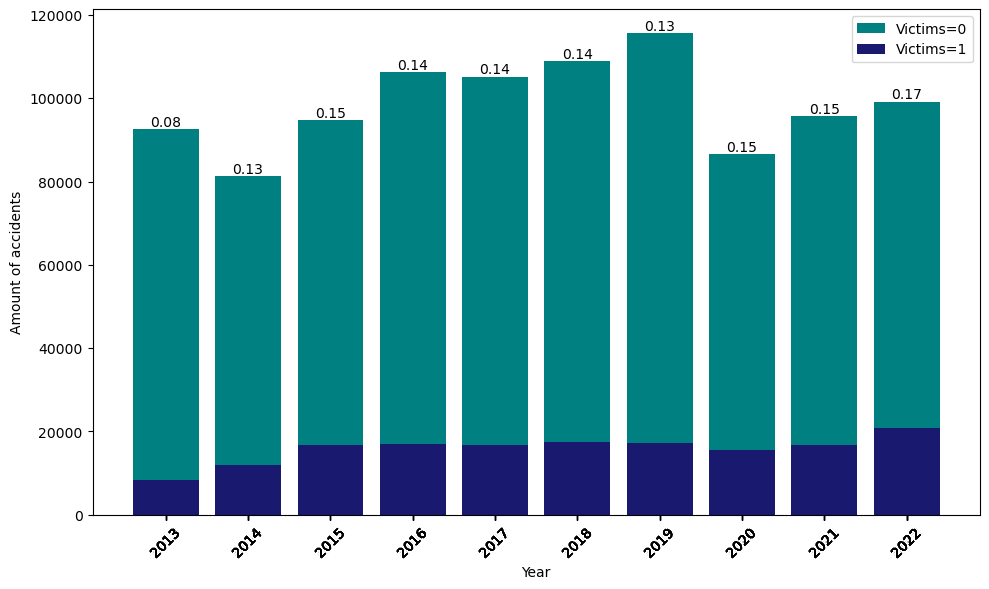

In [43]:
accidents_per_year = merged_data.groupby(['JAAR_VKL', 'ANTL_SLA_x']).size().reset_index(name='Aantal_Ongelukken')
victims_0 = accidents_per_year[accidents_per_year['ANTL_SLA_x'] == 0].reset_index(drop=True)
victims_1 = accidents_per_year[accidents_per_year['ANTL_SLA_x'] == 1].reset_index(drop=True)
ratios = victims_1['Aantal_Ongelukken'] / (victims_0['Aantal_Ongelukken'] + victims_1['Aantal_Ongelukken'])
plt.figure(figsize=(10, 6))
plt.bar(victims_0['JAAR_VKL'], victims_0['Aantal_Ongelukken'], color='teal', label='Victims=0')
plt.bar(victims_1['JAAR_VKL'], victims_1['Aantal_Ongelukken'], color='midnightblue', label='Victims=1')

for i in range(len(ratios)):
    plt.text(victims_0['JAAR_VKL'][i], victims_0['Aantal_Ongelukken'][i], f'{ratios[i]:.2f}', ha='center', va='bottom')

plt.xlabel('Year')
plt.ylabel('Amount of accidents')
plt.xticks(accidents_per_year['JAAR_VKL'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.0)
plt.legend()
plt.tight_layout()
plt.show()

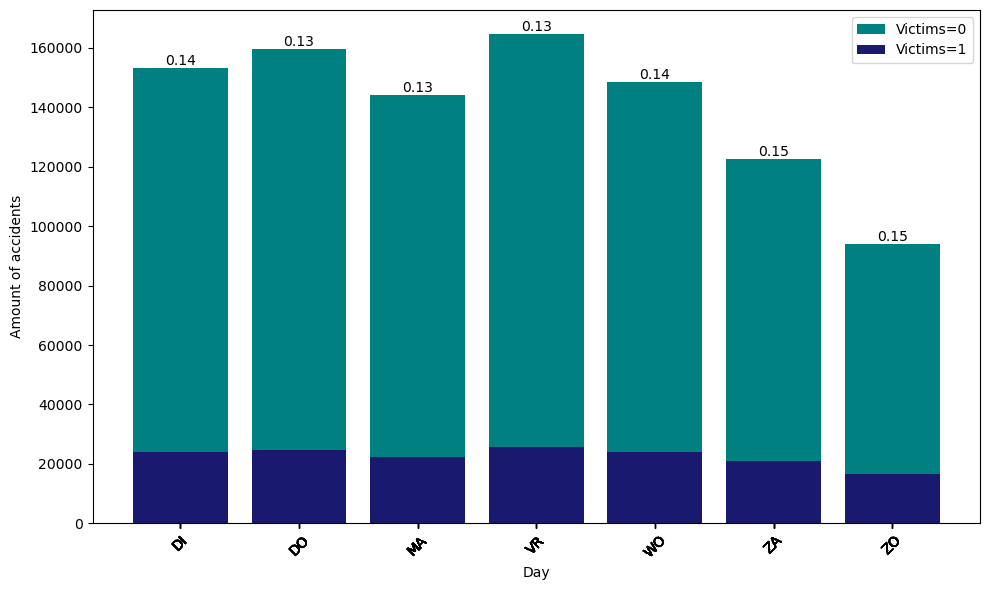

In [44]:
accidents_per_year = merged_data.groupby(['DAG_CODE_x', 'ANTL_SLA_x']).size().reset_index(name='Aantal_Ongelukken')
victims_0 = accidents_per_year[accidents_per_year['ANTL_SLA_x'] == 0].reset_index(drop=True)
victims_1 = accidents_per_year[accidents_per_year['ANTL_SLA_x'] == 1].reset_index(drop=True)
ratios = victims_1['Aantal_Ongelukken'] / (victims_0['Aantal_Ongelukken'] + victims_1['Aantal_Ongelukken'])
plt.figure(figsize=(10, 6))
plt.bar(victims_0['DAG_CODE_x'], victims_0['Aantal_Ongelukken'], color='teal', label='Victims=0')
plt.bar(victims_1['DAG_CODE_x'], victims_1['Aantal_Ongelukken'], color='midnightblue', label='Victims=1')

for i in range(len(ratios)):
    plt.text(victims_0['DAG_CODE_x'][i], victims_0['Aantal_Ongelukken'][i], f'{ratios[i]:.2f}', ha='center', va='bottom')

plt.xlabel('Day')
plt.ylabel('Amount of accidents')
plt.xticks(accidents_per_year['DAG_CODE_x'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.0)
plt.legend()
plt.tight_layout()
plt.show()

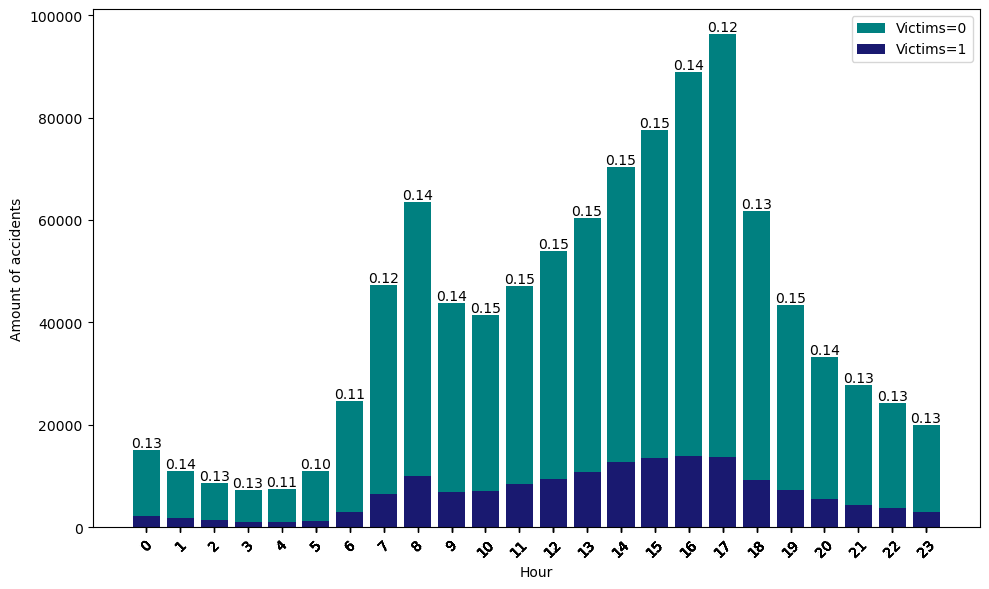

In [45]:
accidents_per_year = merged_data.groupby(['UUR_x', 'ANTL_SLA_x']).size().reset_index(name='Aantal_Ongelukken')
victims_0 = accidents_per_year[accidents_per_year['ANTL_SLA_x'] == 0].reset_index(drop=True)
victims_1 = accidents_per_year[accidents_per_year['ANTL_SLA_x'] == 1].reset_index(drop=True)
ratios = victims_1['Aantal_Ongelukken'] / (victims_0['Aantal_Ongelukken'] + victims_1['Aantal_Ongelukken'])
plt.figure(figsize=(10, 6))
plt.bar(victims_0['UUR_x'], victims_0['Aantal_Ongelukken'], color='teal', label='Victims=0')
plt.bar(victims_1['UUR_x'], victims_1['Aantal_Ongelukken'], color='midnightblue', label='Victims=1')

for i in range(len(ratios)):
    plt.text(victims_0['UUR_x'][i], victims_0['Aantal_Ongelukken'][i], f'{ratios[i]:.2f}', ha='center', va='bottom')

plt.xlabel('Hour')
plt.ylabel('Amount of accidents')
plt.xticks(accidents_per_year['UUR_x'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.0)
plt.legend()
plt.tight_layout()
plt.show()

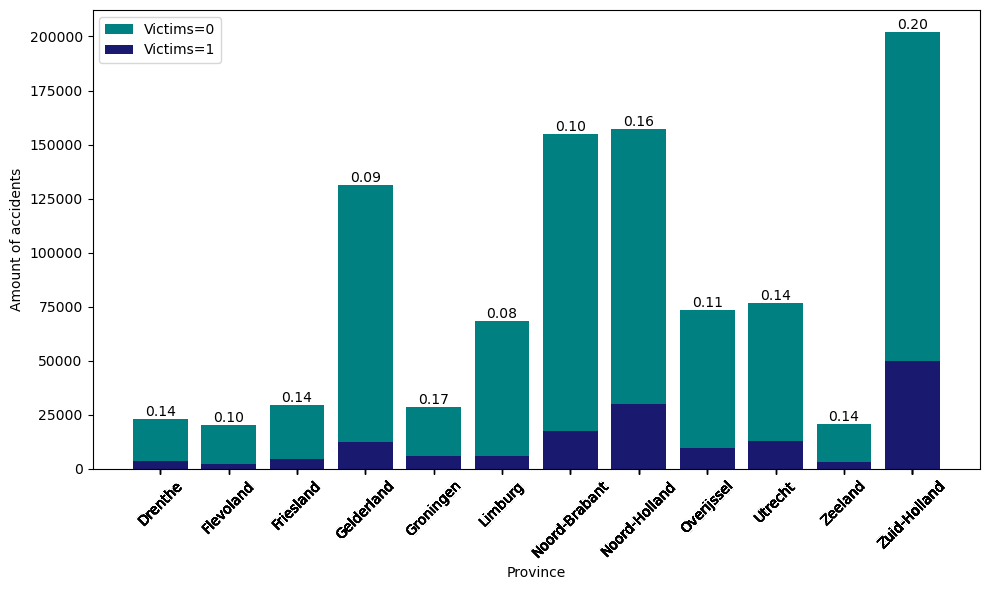

In [46]:
accidents_per_year = merged_data.groupby(['PVE_NAAM', 'ANTL_SLA_x']).size().reset_index(name='Aantal_Ongelukken')
victims_0 = accidents_per_year[accidents_per_year['ANTL_SLA_x'] == 0].reset_index(drop=True)
victims_1 = accidents_per_year[accidents_per_year['ANTL_SLA_x'] == 1].reset_index(drop=True)
ratios = victims_1['Aantal_Ongelukken'] / (victims_0['Aantal_Ongelukken'] + victims_1['Aantal_Ongelukken'])
plt.figure(figsize=(10, 6))
plt.bar(victims_0['PVE_NAAM'], victims_0['Aantal_Ongelukken'], color='teal', label='Victims=0')
plt.bar(victims_1['PVE_NAAM'], victims_1['Aantal_Ongelukken'], color='midnightblue', label='Victims=1')

for i in range(len(ratios)):
    plt.text(victims_0['PVE_NAAM'][i], victims_0['Aantal_Ongelukken'][i], f'{ratios[i]:.2f}', ha='center', va='bottom')

plt.xlabel('Province')
plt.ylabel('Amount of accidents')
plt.xticks(accidents_per_year['PVE_NAAM'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.0)
plt.legend()
plt.tight_layout()
plt.show()

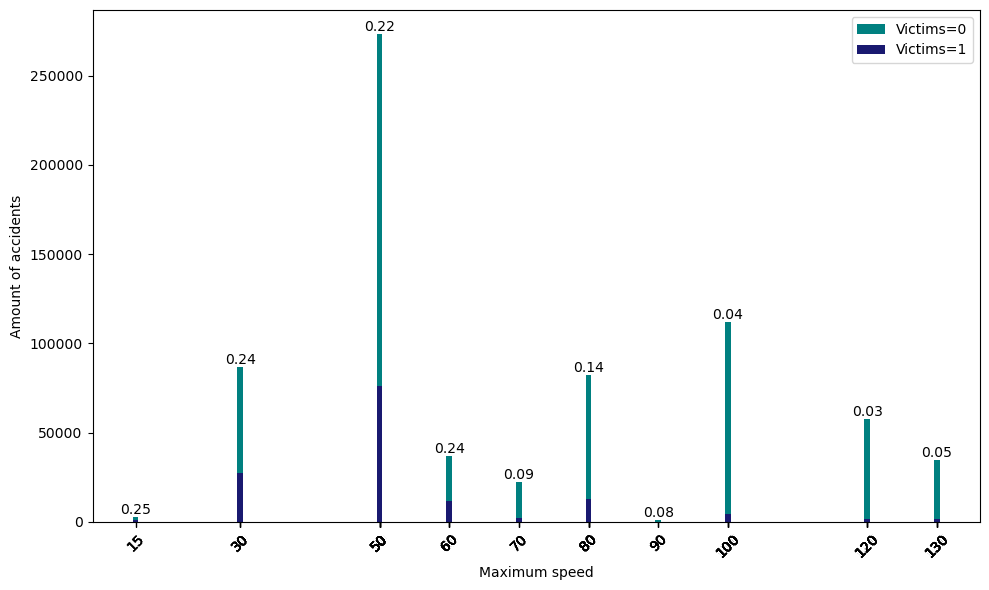

In [47]:
accidents_per_year = merged_data.groupby(['MAXSNELHD', 'ANTL_SLA_x']).size().reset_index(name='Aantal_Ongelukken')
victims_0 = accidents_per_year[accidents_per_year['ANTL_SLA_x'] == 0].reset_index(drop=True)
victims_1 = accidents_per_year[accidents_per_year['ANTL_SLA_x'] == 1].reset_index(drop=True)
ratios = victims_1['Aantal_Ongelukken'] / (victims_0['Aantal_Ongelukken'] + victims_1['Aantal_Ongelukken'])
plt.figure(figsize=(10, 6))
plt.bar(victims_0['MAXSNELHD'], victims_0['Aantal_Ongelukken'], color='teal', label='Victims=0')
plt.bar(victims_1['MAXSNELHD'], victims_1['Aantal_Ongelukken'], color='midnightblue', label='Victims=1')

for i in range(len(ratios)):
    plt.text(victims_0['MAXSNELHD'][i], victims_0['Aantal_Ongelukken'][i], f'{ratios[i]:.2f}', ha='center', va='bottom')

plt.xlabel('Maximum speed')
plt.ylabel('Amount of accidents')
plt.xticks(accidents_per_year['MAXSNELHD'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.0)
plt.legend()
plt.tight_layout()
plt.show()

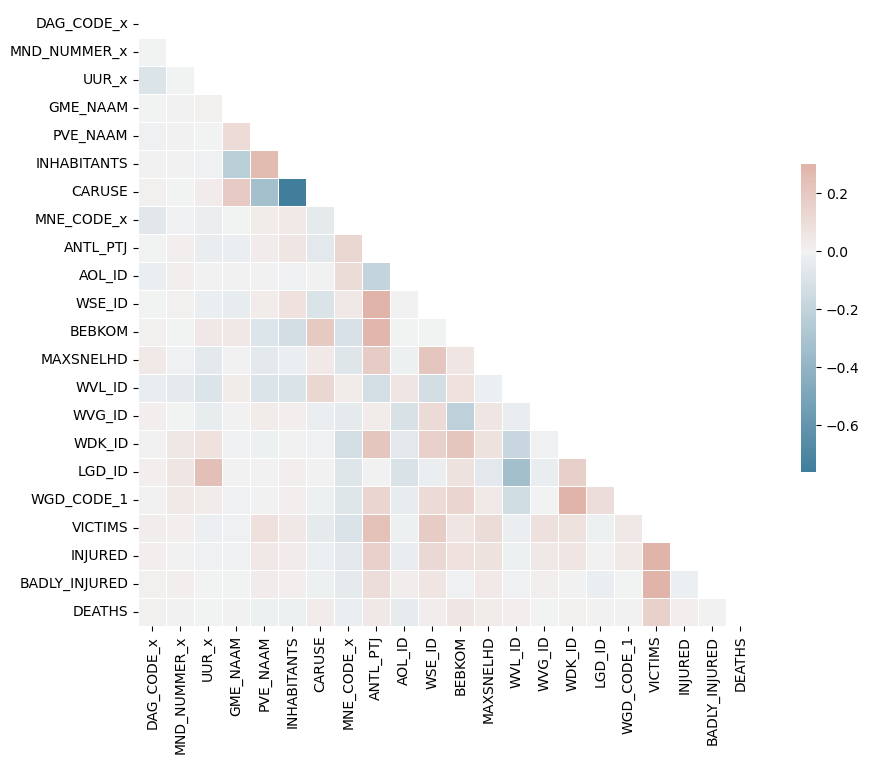

In [11]:
corr = final.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 8))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [12]:
from sklearn.model_selection import train_test_split

sample_size = 100000
sampled_data = final.sample(n=sample_size, random_state=42)
X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

feature_importances = rf_classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
feature_names = list(X.columns)

y_val_pred = rf_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Accuracy:", val_accuracy)
print("Classification Report:")
print(classification_report(y_val, y_val_pred))


Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      8563
           1       0.61      0.26      0.36      1437

    accuracy                           0.87     10000
   macro avg       0.75      0.62      0.65     10000
weighted avg       0.85      0.87      0.85     10000



In [13]:
from sklearn.model_selection import train_test_split

sample_size = 100000
data_with_victims_0 = final[final['VICTIMS'] == 0]
data_with_victims_1 = final[final['VICTIMS'] == 1]

sample_size_per_class = sample_size // 2
random_indices_0 = np.random.choice(len(data_with_victims_0), sample_size_per_class)
random_indices_1 = np.random.choice(len(data_with_victims_1), sample_size_per_class)
sampled_data = pd.concat([data_with_victims_0.iloc[random_indices_0], data_with_victims_1.iloc[random_indices_1]])

X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

feature_importances = rf_classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
feature_names = list(X.columns)

y_val_pred = rf_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Accuracy:", val_accuracy)
print("\ Classification Report:")
print(classification_report(y_val, y_val_pred))

Accuracy: 0.7845
\ Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      5015
           1       0.75      0.84      0.80      4985

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



In [14]:
from sklearn.model_selection import train_test_split

sample_size = 100000
sampled_data = final.sample(n=sample_size, random_state=42)
X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

y_val_pred = xgb_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Accuracy:", val_accuracy)
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

Accuracy: 0.8743
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      8563
           1       0.64      0.28      0.39      1437

    accuracy                           0.87     10000
   macro avg       0.77      0.63      0.66     10000
weighted avg       0.85      0.87      0.85     10000



In [15]:
from sklearn.model_selection import train_test_split

sample_size = 100000
data_with_victims_0 = final[final['VICTIMS'] == 0]
data_with_victims_1 = final[final['VICTIMS'] == 1]

sample_size_per_class = sample_size // 2
random_indices_0 = np.random.choice(len(data_with_victims_0), sample_size_per_class)
random_indices_1 = np.random.choice(len(data_with_victims_1), sample_size_per_class)
sampled_data = pd.concat([data_with_victims_0.iloc[random_indices_0], data_with_victims_1.iloc[random_indices_1]])

X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

y_val_pred = xgb_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Validation Accuracy:", val_accuracy)
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7747
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76      4996
           1       0.74      0.85      0.79      5004

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



In [16]:
from sklearn.model_selection import train_test_split

sample_size = 100000
sampled_data = final.sample(n=sample_size, random_state=42)
X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train, y_train)

y_val_pred = logistic_regression.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Accuracy:", val_accuracy)
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

Accuracy: 0.8413
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      8563
           1       0.22      0.04      0.07      1437

    accuracy                           0.84     10000
   macro avg       0.54      0.51      0.49     10000
weighted avg       0.77      0.84      0.79     10000



C:\Users\rami1\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
from sklearn.model_selection import train_test_split

sample_size = 100000
data_with_victims_0 = final[final['VICTIMS'] == 0]
data_with_victims_1 = final[final['VICTIMS'] == 1]

sample_size_per_class = sample_size // 2
random_indices_0 = np.random.choice(len(data_with_victims_0), sample_size_per_class)
random_indices_1 = np.random.choice(len(data_with_victims_1), sample_size_per_class)
sampled_data = pd.concat([data_with_victims_0.iloc[random_indices_0], data_with_victims_1.iloc[random_indices_1]])

X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train, y_train)

y_val_pred = logistic_regression.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Validation Accuracy:", val_accuracy)
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.5004
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4996
           1       0.50      1.00      0.67      5004

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



C:\Users\rami1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rami1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rami1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

sample_size = 100000
sampled_data = final.sample(n=sample_size, random_state=42)
X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train)

y_val_pred = mlp_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Accuracy:", val_accuracy)
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

Accuracy: 0.8563
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      8563
           1       0.00      0.00      0.00      1437

    accuracy                           0.86     10000
   macro avg       0.43      0.50      0.46     10000
weighted avg       0.73      0.86      0.79     10000



C:\Users\rami1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rami1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rami1\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

sample_size = 100000
data_with_victims_0 = final[final['VICTIMS'] == 0]
data_with_victims_1 = final[final['VICTIMS'] == 1]

sample_size_per_class = sample_size // 2
random_indices_0 = np.random.choice(len(data_with_victims_0), sample_size_per_class)
random_indices_1 = np.random.choice(len(data_with_victims_1), sample_size_per_class)
sampled_data = pd.concat([data_with_victims_0.iloc[random_indices_0], data_with_victims_1.iloc[random_indices_1]])

X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train)

y_val_pred = mlp_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Validation Accuracy:", val_accuracy)
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.5294

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.92      0.66      4996
           1       0.63      0.14      0.23      5004

    accuracy                           0.53     10000
   macro avg       0.58      0.53      0.45     10000
weighted avg       0.58      0.53      0.45     10000



**Hyperparameter tuning the optimal model**

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

sample_size = 100000
data_with_victims_0 = final[final['VICTIMS'] == 0]
data_with_victims_1 = final[final['VICTIMS'] == 1]

sample_size_per_class = sample_size // 2
random_indices_0 = np.random.choice(len(data_with_victims_0), sample_size_per_class)
random_indices_1 = np.random.choice(len(data_with_victims_1), sample_size_per_class)
sampled_data = pd.concat([data_with_victims_0.iloc[random_indices_0], data_with_victims_1.iloc[random_indices_1]])

X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

rf_classifier = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params_grid = grid_search.best_params_
best_rf_grid = grid_search.best_estimator_
y_val_pred_grid = best_rf_grid.predict(X_val)
val_accuracy_grid = accuracy_score(y_val, y_val_pred_grid)

print("Grid Search Best Parameters:", best_params_grid)
print("Validation Accuracy after Grid Search:", val_accuracy_grid)
print("Classification Report after Grid Search:")
print(classification_report(y_val, y_val_pred_grid))


Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\rami1\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Grid Search Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 300}
Validation Accuracy after Grid Search: 0.7811
Classification Report after Grid Search:
              precision    recall  f1-score   support

           0       0.86      0.67      0.76      5015
           1       0.73      0.89      0.80      4985

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

sample_size = 100000
data_with_victims_0 = final[final['VICTIMS'] == 0]
data_with_victims_1 = final[final['VICTIMS'] == 1]

sample_size_per_class = sample_size // 2
random_indices_0 = np.random.choice(len(data_with_victims_0), sample_size_per_class)
random_indices_1 = np.random.choice(len(data_with_victims_1), sample_size_per_class)
sampled_data = pd.concat([data_with_victims_0.iloc[random_indices_0], data_with_victims_1.iloc[random_indices_1]])

X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

rf_classifier = RandomForestClassifier()

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'criterion': ['gini', 'entropy']
}

n_iter_search = 10
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, 
                                   n_iter=n_iter_search, cv=3, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)

best_params_random = random_search.best_params_
best_rf_random = random_search.best_estimator_
y_val_pred_random = best_rf_random.predict(X_val)
val_accuracy_random = accuracy_score(y_val, y_val_pred_random)

print("Randomized Search Best Parameters:", best_params_random)
print("Validation Accuracy after Randomized Search:", val_accuracy_random)
print("Classification Report after Randomized Search:")
print(classification_report(y_val, y_val_pred_random))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized Search Best Parameters: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'gini'}
Validation Accuracy after Randomized Search: 0.794
Classification Report after Randomized Search:
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      5015
           1       0.76      0.86      0.81      4985

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



**Performance of the optimal model**

In [74]:
from sklearn.model_selection import train_test_split

sample_size = 100000
data_with_victims_0 = final[final['VICTIMS'] == 0]
data_with_victims_1 = final[final['VICTIMS'] == 1]

sample_size_per_class = sample_size // 2
random_indices_0 = np.random.choice(len(data_with_victims_0), sample_size_per_class)
random_indices_1 = np.random.choice(len(data_with_victims_1), sample_size_per_class)
sampled_data = pd.concat([data_with_victims_0.iloc[random_indices_0], data_with_victims_1.iloc[random_indices_1]])

X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=200, max_features='log2', max_depth=30, criterion='gini')
rf_classifier.fit(X_train, y_train)

feature_importances = rf_classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
feature_names = list(X.columns)

y_test_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Accuracy:", test_accuracy)
print("\ Classification Report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.7861
\ Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77      5020
           1       0.75      0.86      0.80      4980

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [71]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[3589 1431]
 [ 715 4265]]


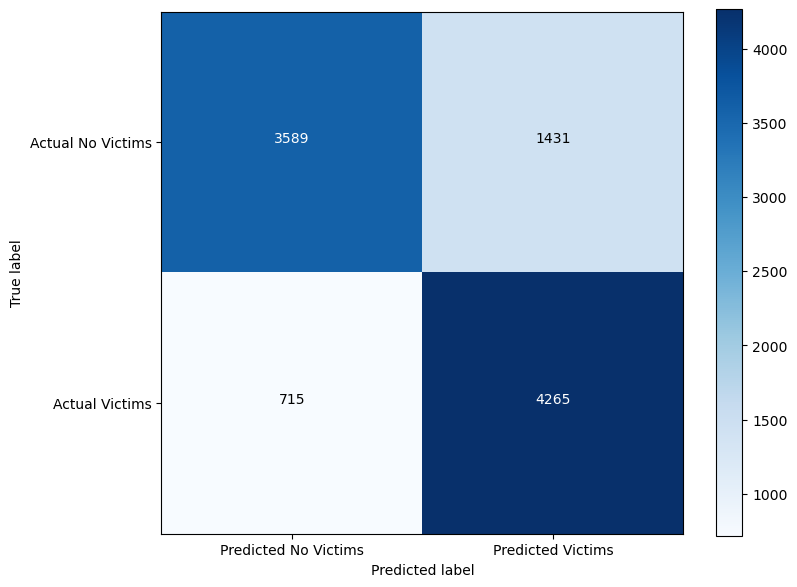

In [73]:
conf_matrix = np.array([[3589, 1431],
                        [715, 4265]])

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xticks(np.arange(2), ['Predicted No Victims', 'Predicted Victims'], rotation=0)
plt.yticks(np.arange(2), ['Actual No Victims', 'Actual Victims'])
plt.grid(False)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

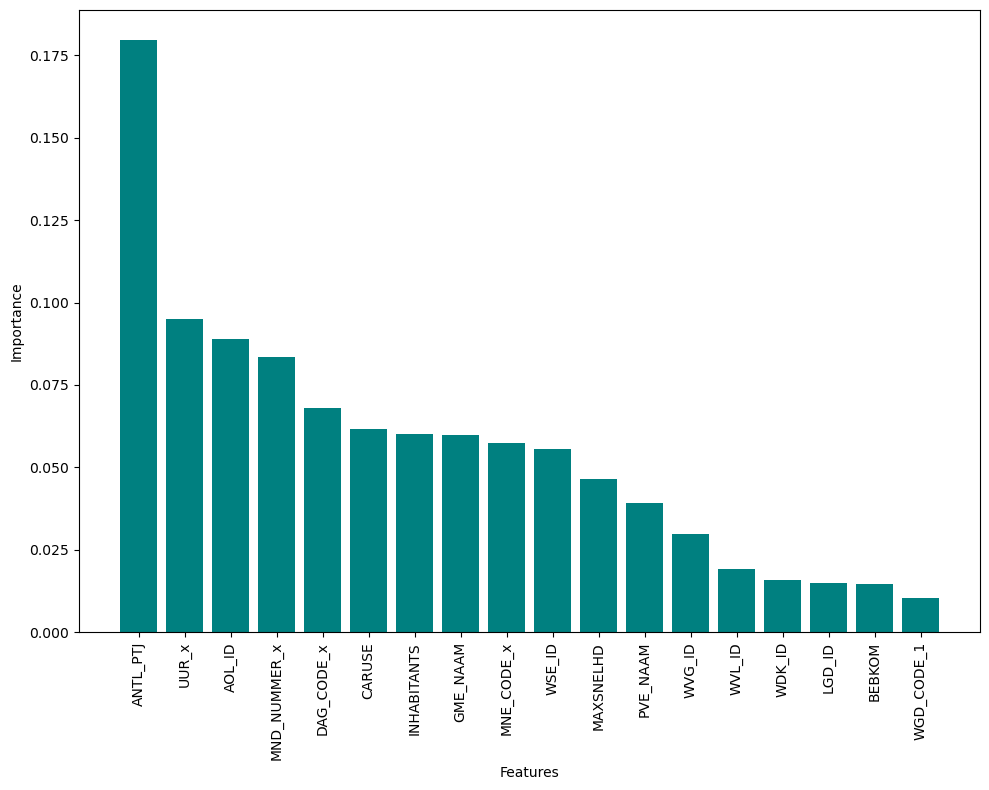

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

sample_size = 100000
data_with_victims_0 = final[final['VICTIMS'] == 0]
data_with_victims_1 = final[final['VICTIMS'] == 1]

sample_size_per_class = sample_size // 2
random_indices_0 = np.random.choice(len(data_with_victims_0), sample_size_per_class, replace=False)
random_indices_1 = np.random.choice(len(data_with_victims_1), sample_size_per_class, replace=False)
sampled_data = pd.concat([data_with_victims_0.iloc[random_indices_0], data_with_victims_1.iloc[random_indices_1]])

X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["VICTIMS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=200, max_features='log2', max_depth=30, criterion='gini')
rf_classifier.fit(X_train, y_train)

feature_importances = rf_classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center', color='teal')
plt.xticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

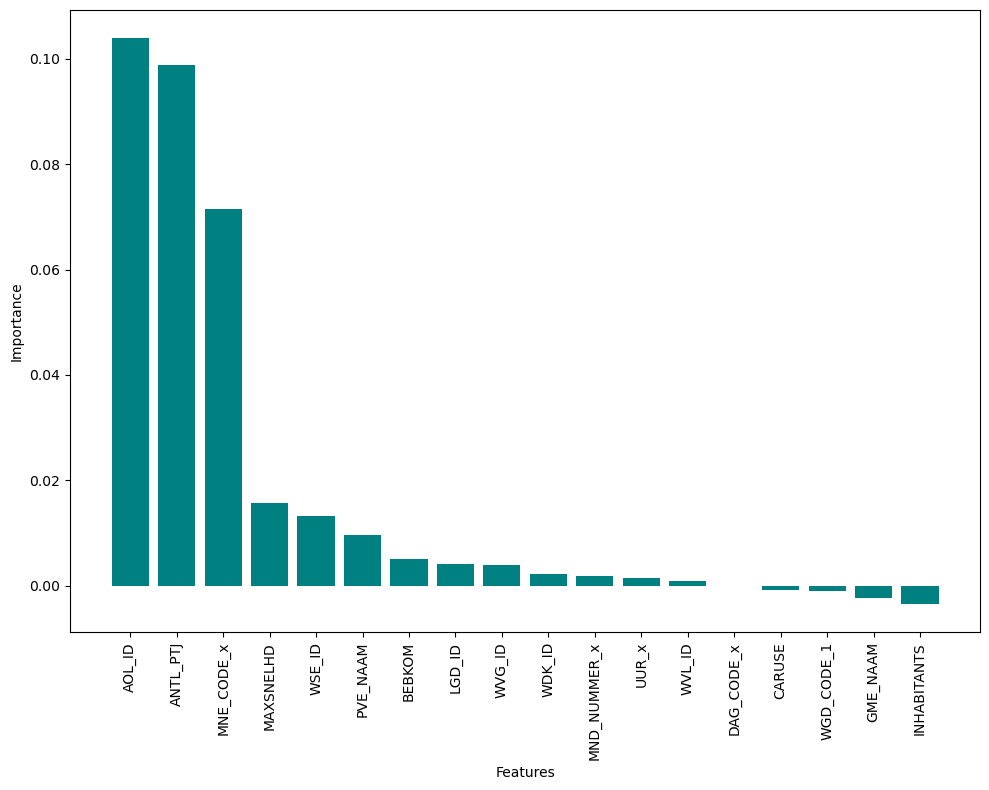

In [52]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf_classifier, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color='teal')
plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

**INJURED**

In [57]:
sample_size = 100000
data_with_injured_0 = final[final['INJURED'] == 0]
data_with_injured_1 = final[final['INJURED'] == 1]

sample_size_per_class = sample_size // 2
random_indices_0 = np.random.choice(len(data_with_injured_0), sample_size_per_class)
random_indices_1 = np.random.choice(len(data_with_injured_1), sample_size_per_class)
sampled_data = pd.concat([data_with_injured_0.iloc[random_indices_0], data_with_injured_1.iloc[random_indices_1]])

X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["INJURED"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=200, max_features='log2', max_depth=30, criterion='gini')
rf_classifier.fit(X_train, y_train)

feature_importances = rf_classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
feature_names = list(X.columns)

y_test_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Accuracy:", test_accuracy)
print("\ Classification Report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.7904
\ Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77      5020
           1       0.75      0.88      0.81      4980

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



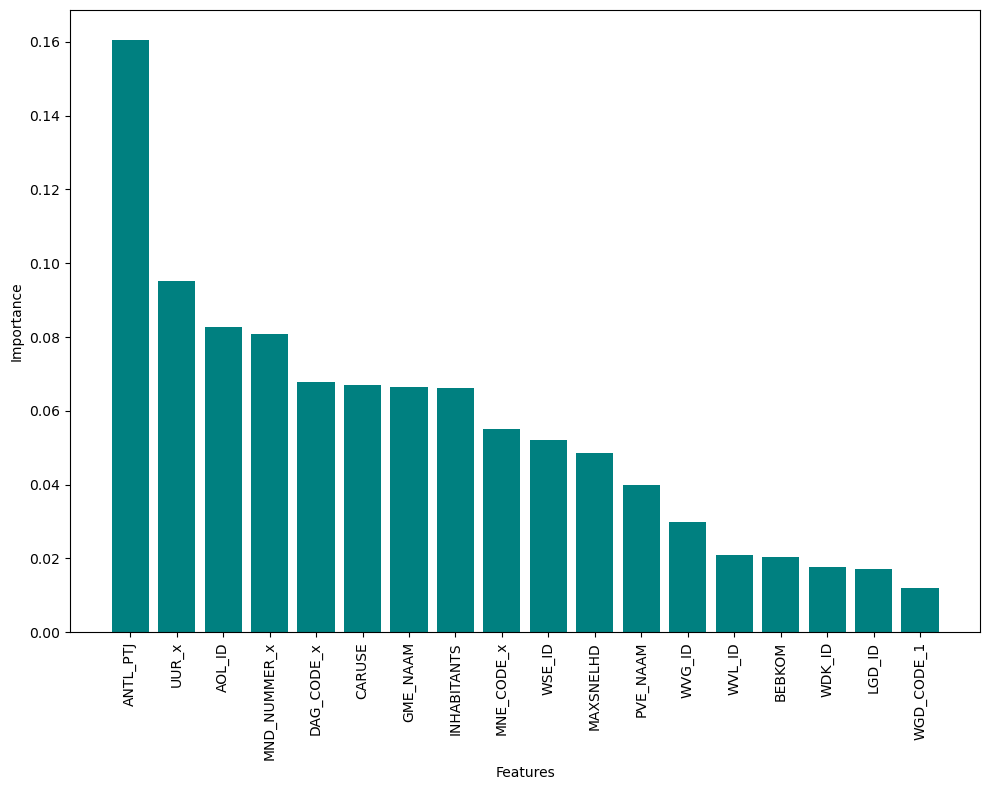

In [58]:
feature_importances = rf_classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center', color='teal')
plt.xticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

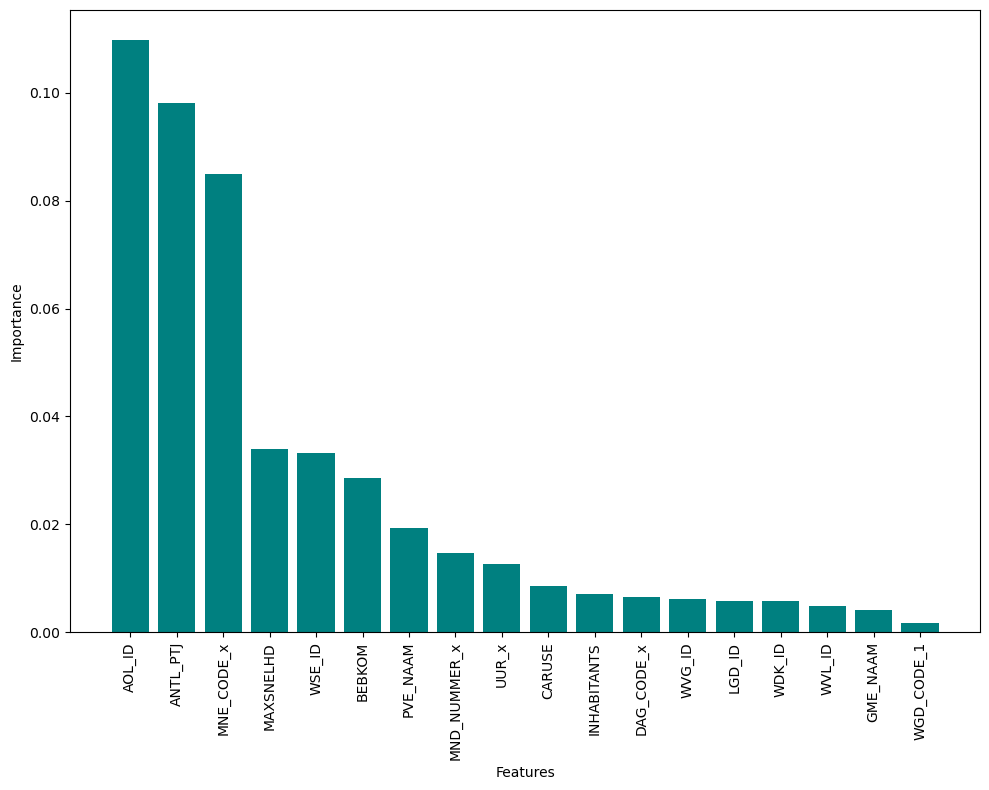

In [59]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf_classifier, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color='teal')
plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

**Badly injured**

In [60]:
sample_size = 10000
data_with_badly_injured_0 = final[final['BADLY_INJURED'] == 0]
data_with_badly_injured_1 = final[final['BADLY_INJURED'] == 1]

sample_size_per_class = sample_size // 2
random_indices_0 = np.random.choice(len(data_with_badly_injured_0), sample_size_per_class)
random_indices_1 = np.random.choice(len(data_with_badly_injured_1), sample_size_per_class)
sampled_data = pd.concat([data_with_badly_injured_0.iloc[random_indices_0], data_with_badly_injured_1.iloc[random_indices_1]])

X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["BADLY_INJURED"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=200, max_features='log2', max_depth=30, criterion='gini')
rf_classifier.fit(X_train, y_train)

feature_importances = rf_classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
feature_names = list(X.columns)

y_test_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Accuracy:", test_accuracy)
print("\ Classification Report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.754
\ Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.74       495
           1       0.74      0.79      0.76       505

    accuracy                           0.75      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.76      0.75      0.75      1000



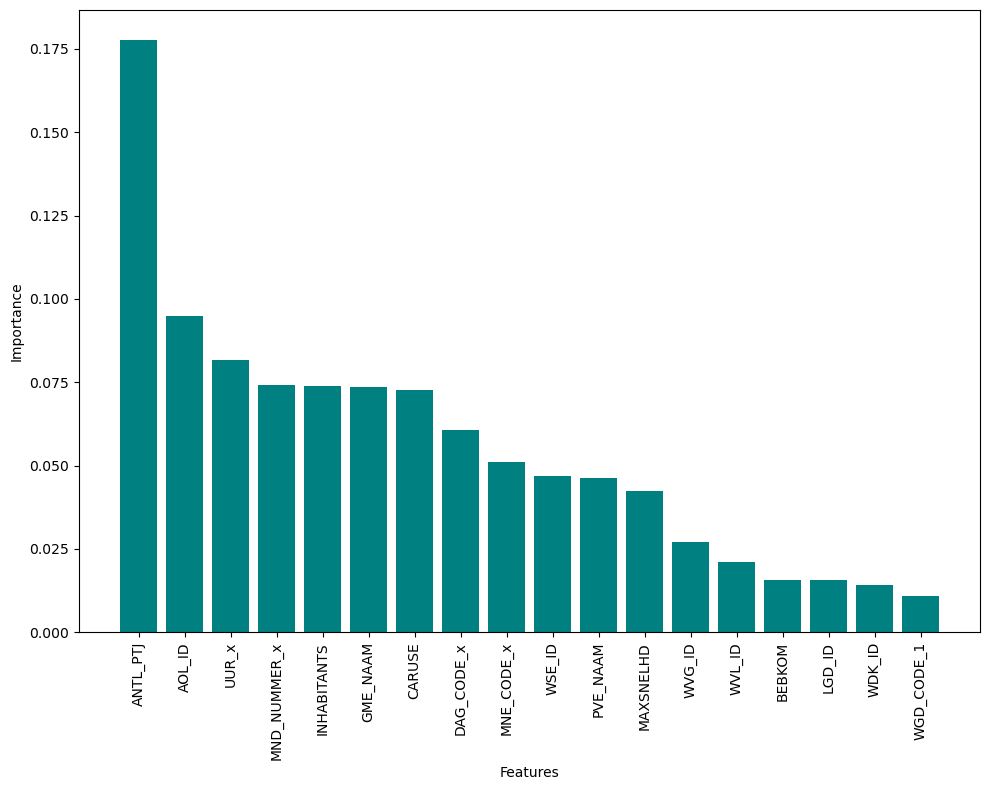

In [61]:
feature_importances = rf_classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center', color='teal')
plt.xticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

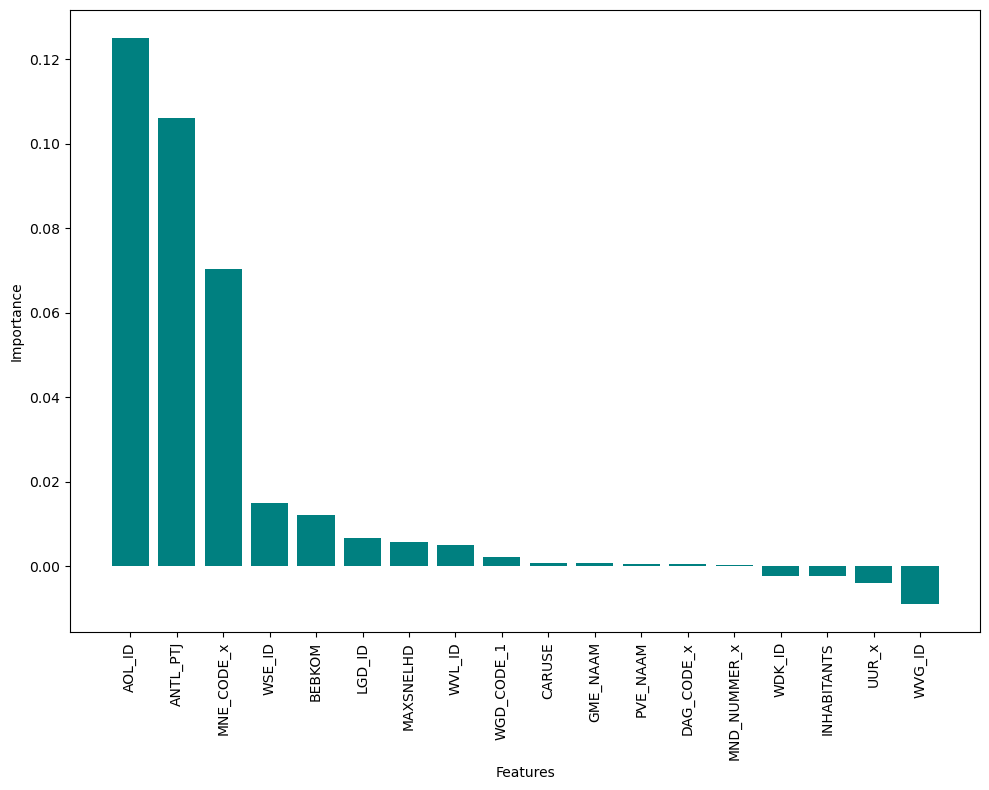

In [62]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf_classifier, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color='teal')
plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

**DEATHS**

In [63]:
sample_size = 10000
data_with_deaths_0 = final[final['DEATHS'] == 0]
data_with_deaths_1 = final[final['DEATHS'] == 1]

sample_size_per_class = sample_size // 2
random_indices_0 = np.random.choice(len(data_with_deaths_0), sample_size_per_class)
random_indices_1 = np.random.choice(len(data_with_deaths_1), sample_size_per_class)
sampled_data = pd.concat([data_with_deaths_0.iloc[random_indices_0], data_with_deaths_1.iloc[random_indices_1]])

X = sampled_data.drop(["VICTIMS", "INJURED", "BADLY_INJURED", "DEATHS"], axis=1)
y = sampled_data["DEATHS"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=200, max_features='log2', max_depth=30, criterion='gini')
rf_classifier.fit(X_train, y_train)

feature_importances = rf_classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
feature_names = list(X.columns)

y_test_pred = rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Accuracy:", test_accuracy)
print("\ Classification Report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.867
\ Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       495
           1       0.85      0.89      0.87       505

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



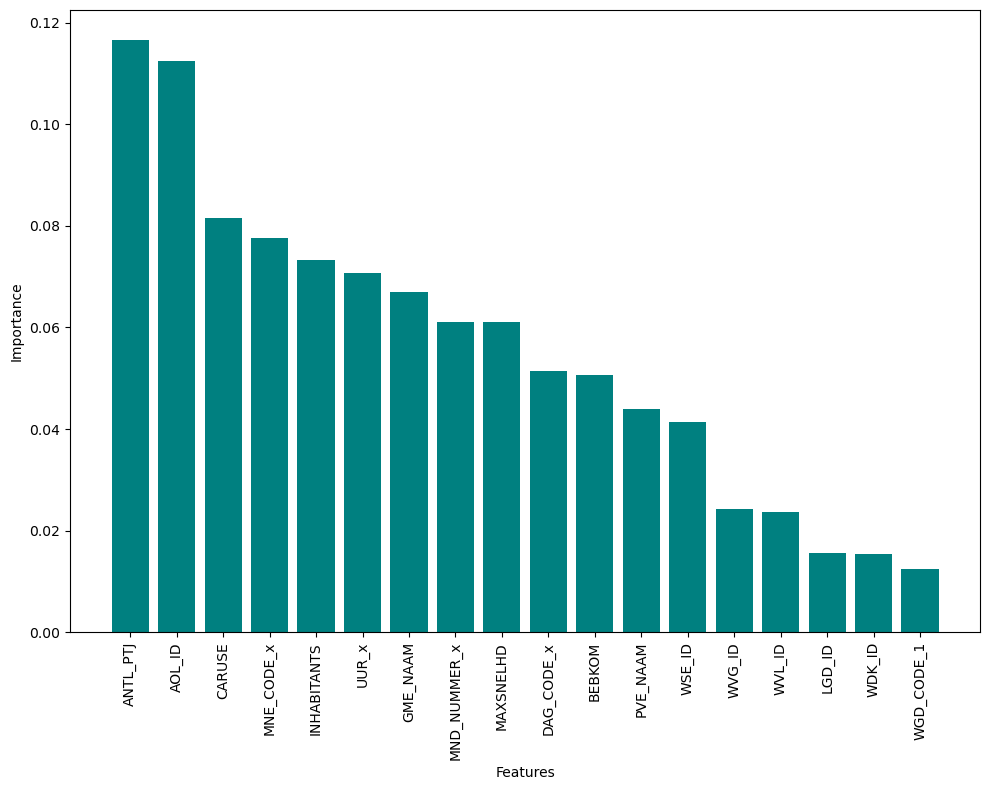

In [64]:
feature_importances = rf_classifier.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices], align='center', color='teal')
plt.xticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

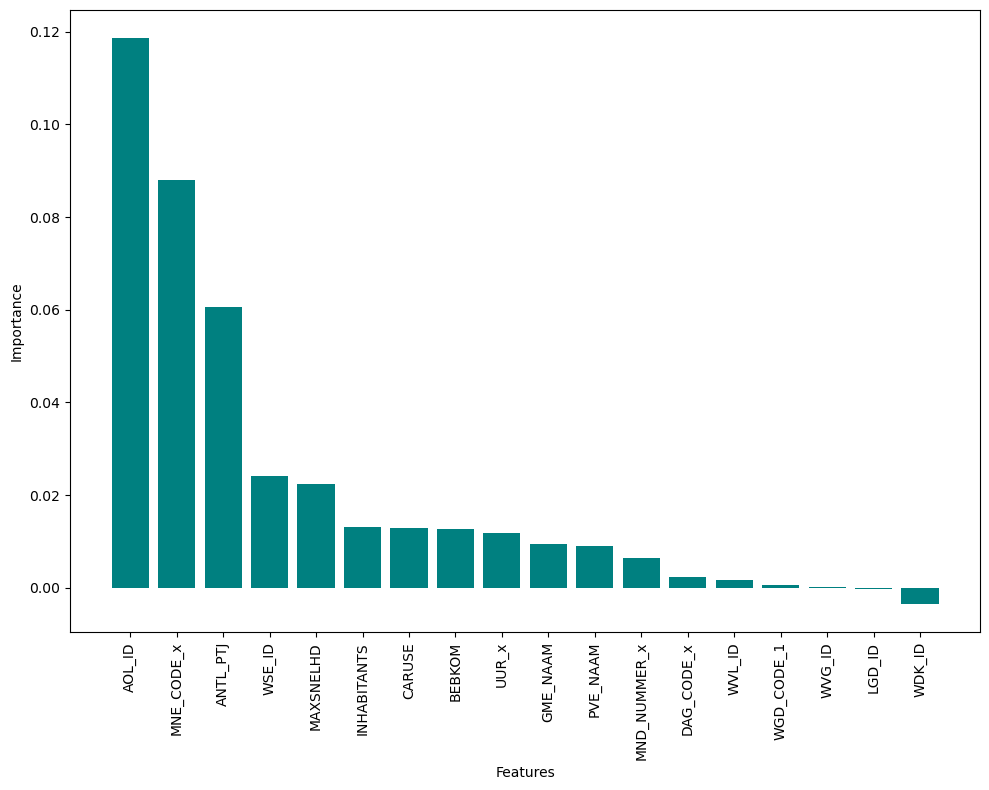

In [65]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf_classifier, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', color='teal')
plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

**Residual analysis**

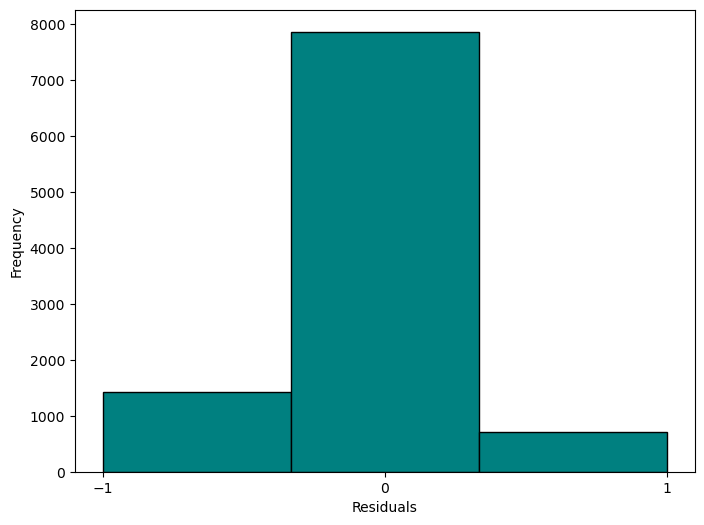

In [81]:
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=3, range=(-1, 1), color='teal', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.xticks([-1, 0, 1])
plt.show()

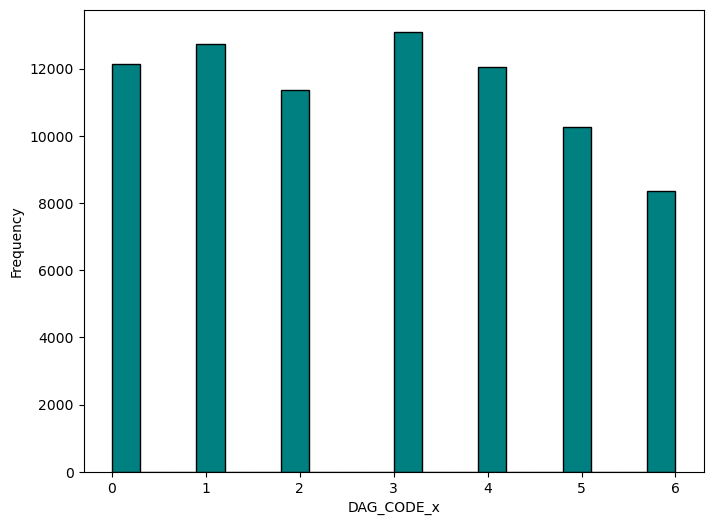

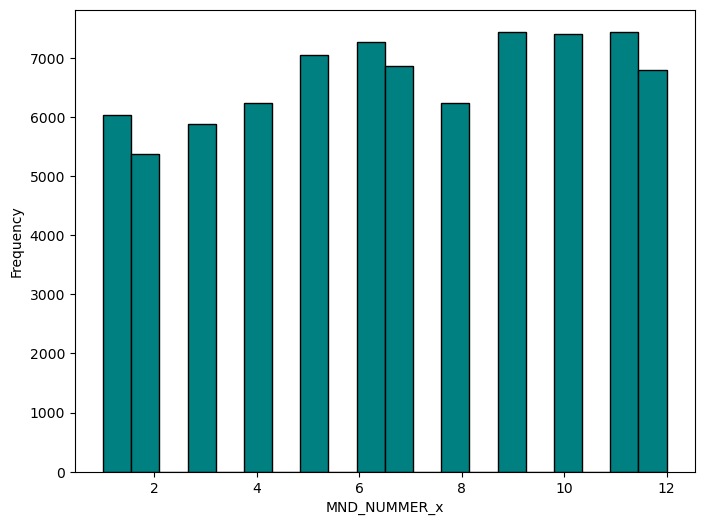

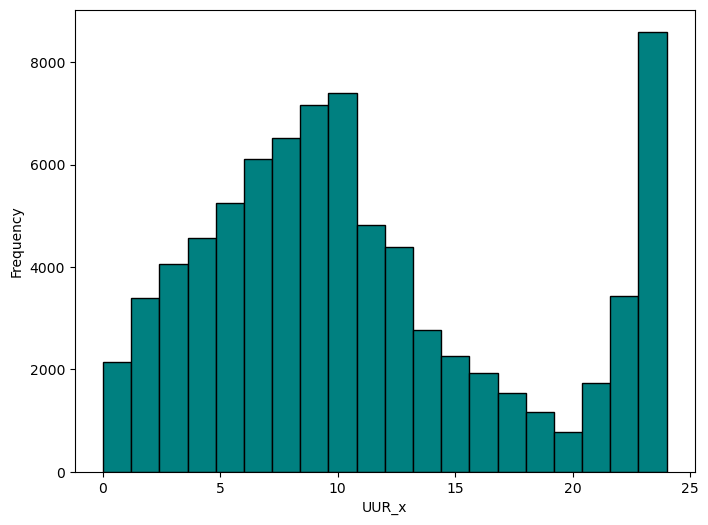

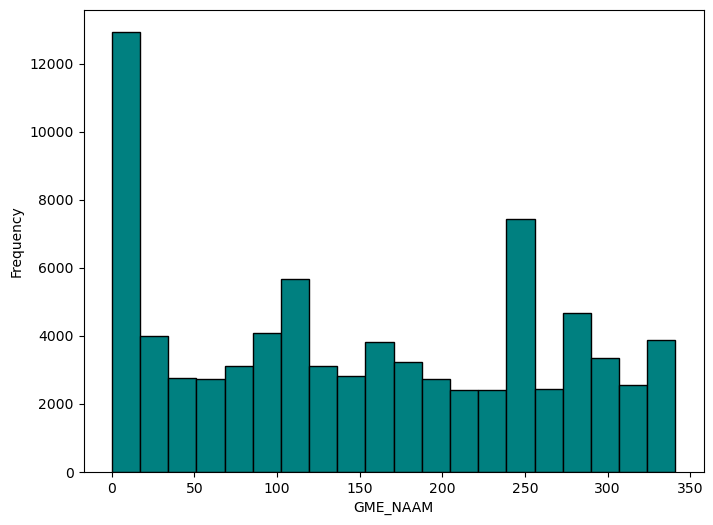

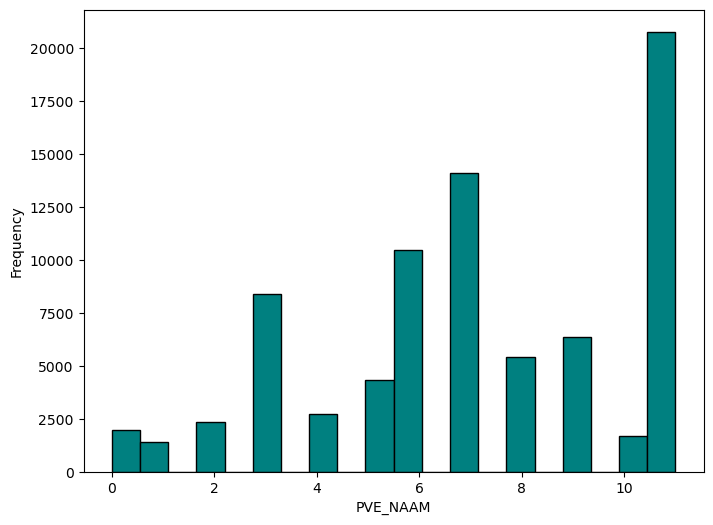

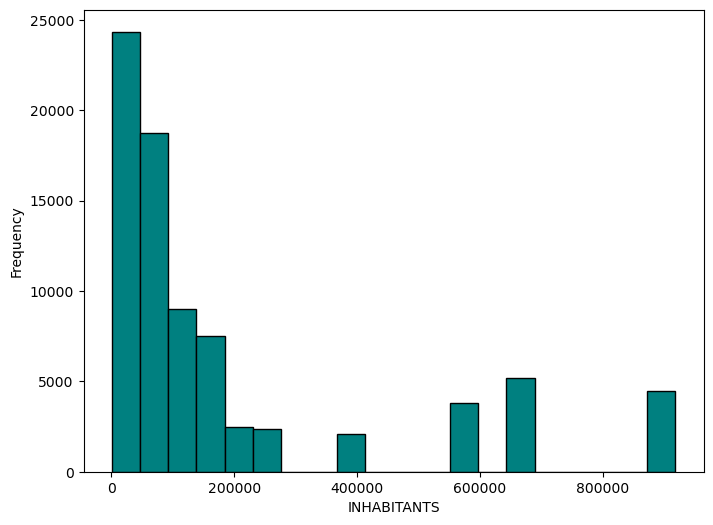

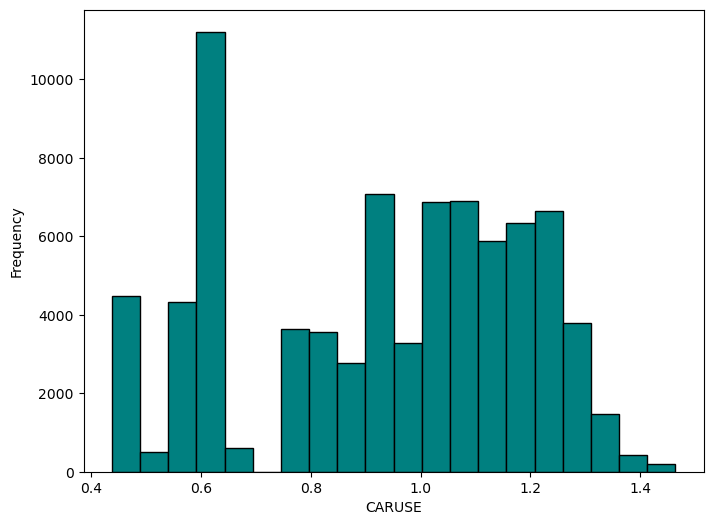

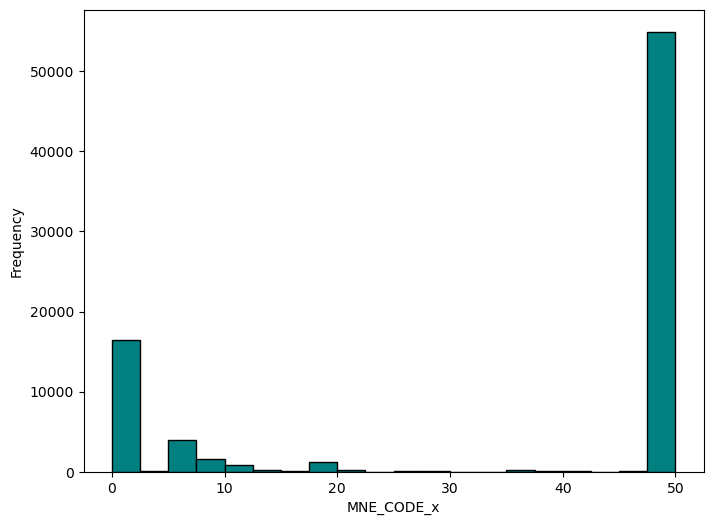

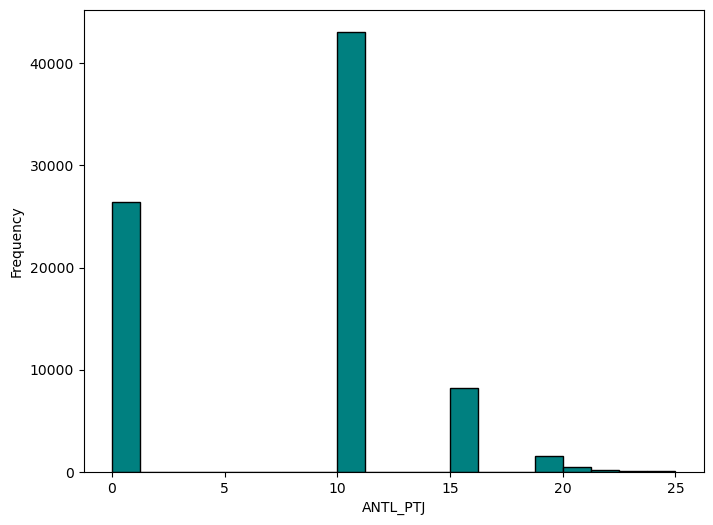

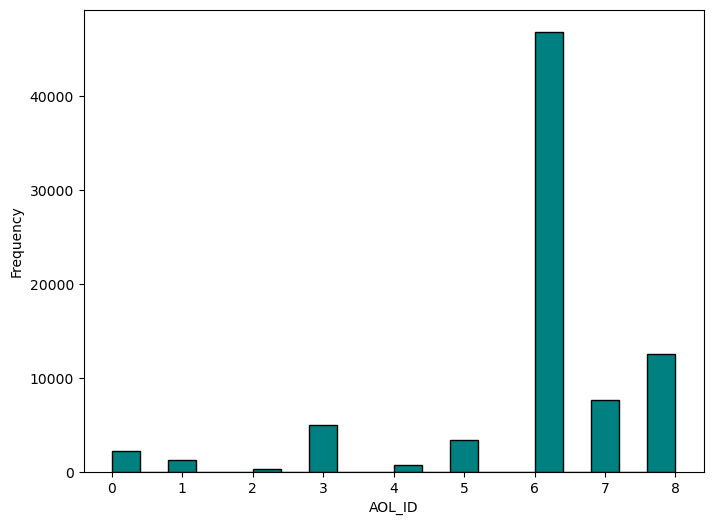

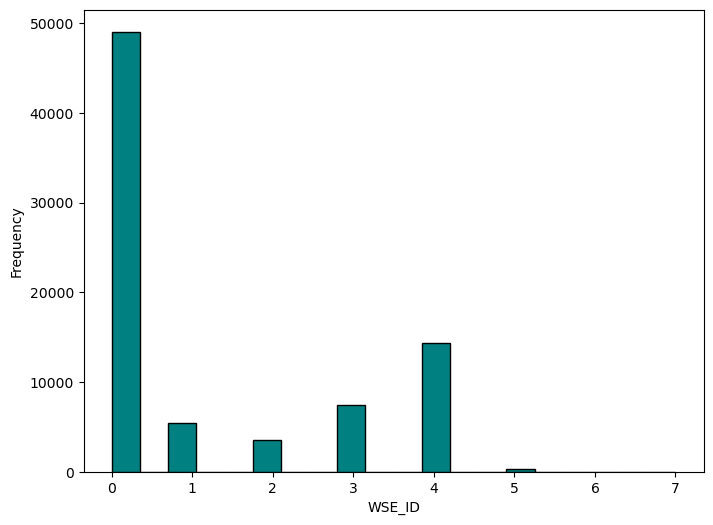

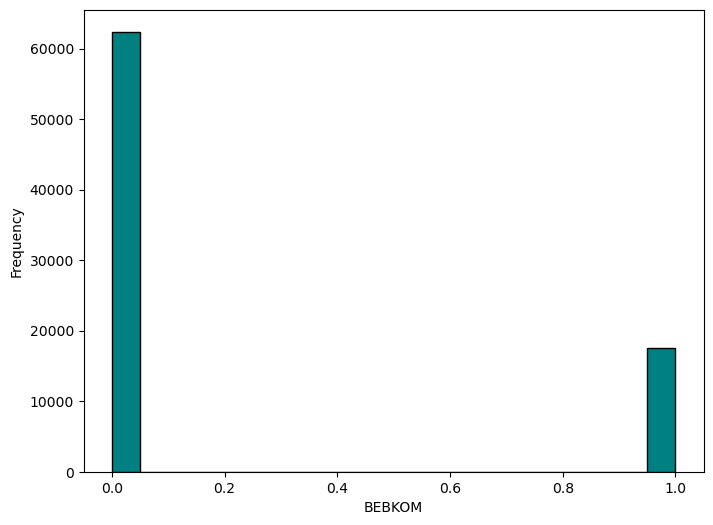

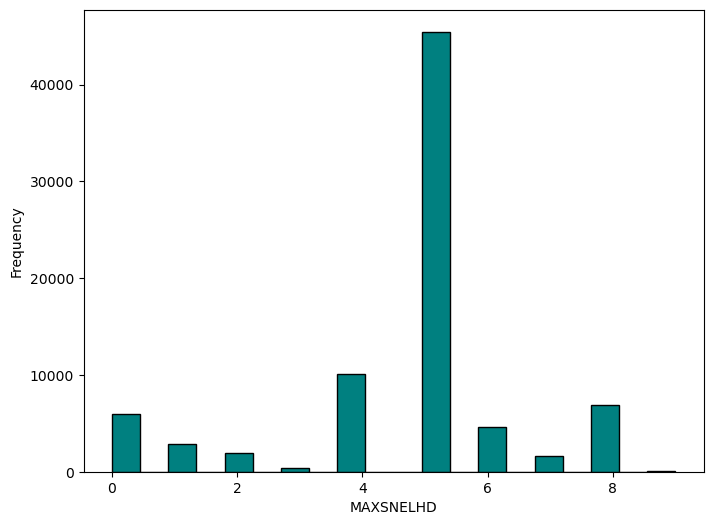

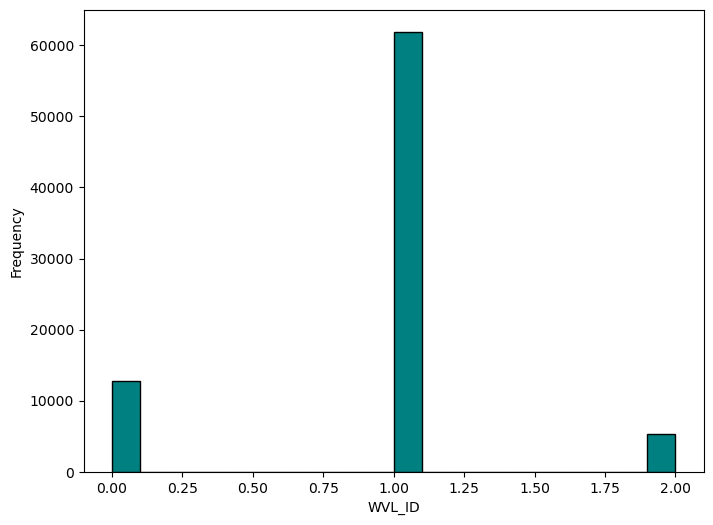

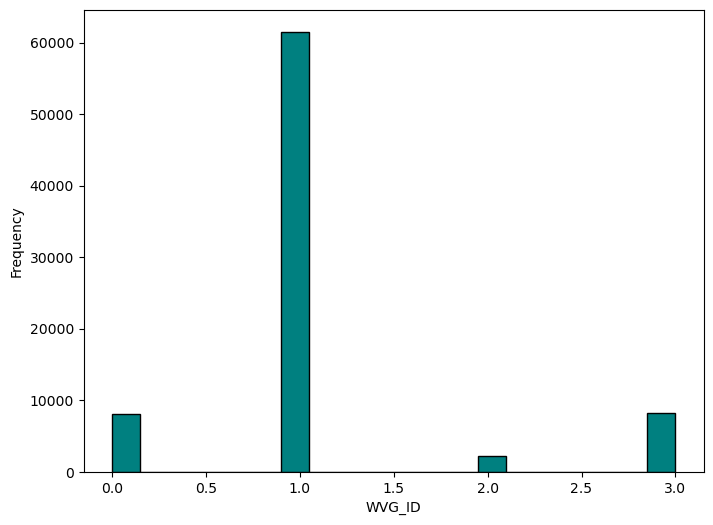

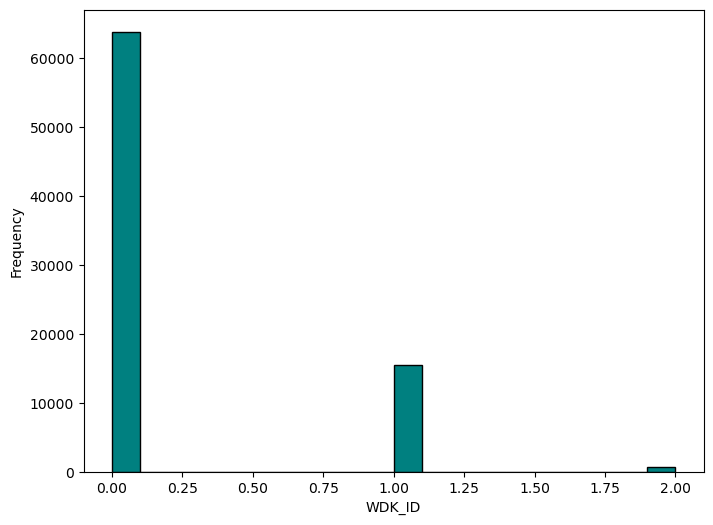

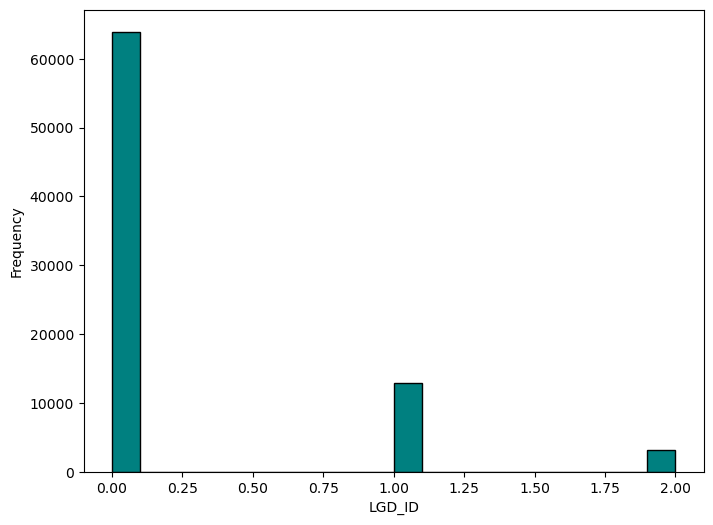

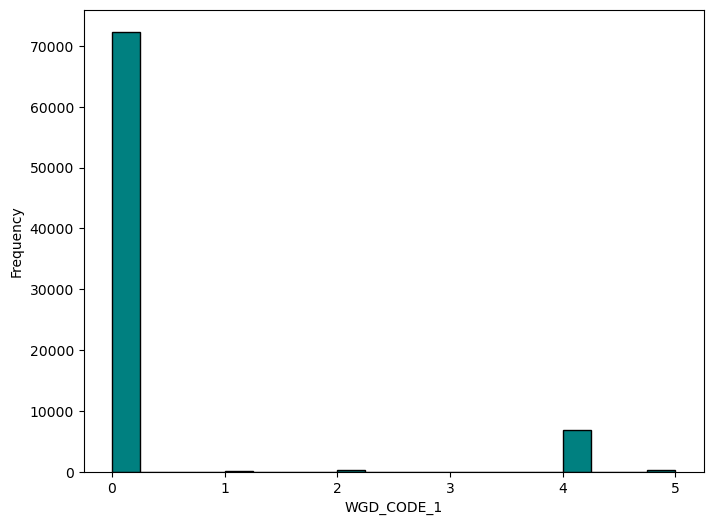

In [82]:
for column in X_train.columns:
    if column not in ['Actual_VICTIMS', 'Predicted_VICTIMS', 'Misclass']:
        plt.figure(figsize=(8, 6))
        X_train[column].plot(kind='hist', bins=20, edgecolor='black', color = 'teal')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

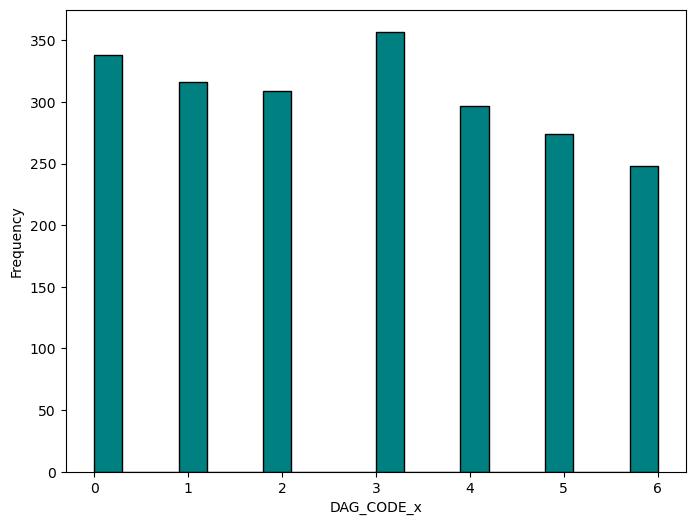

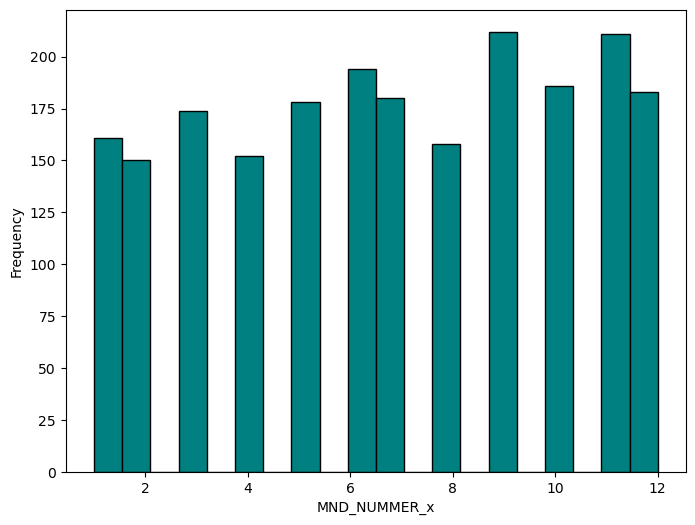

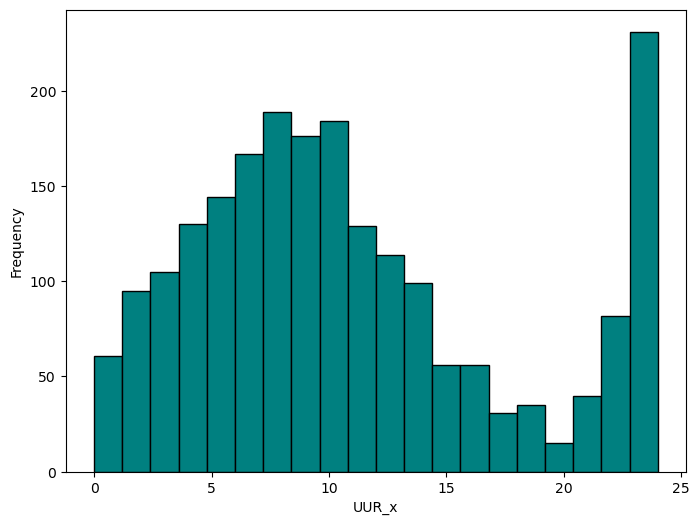

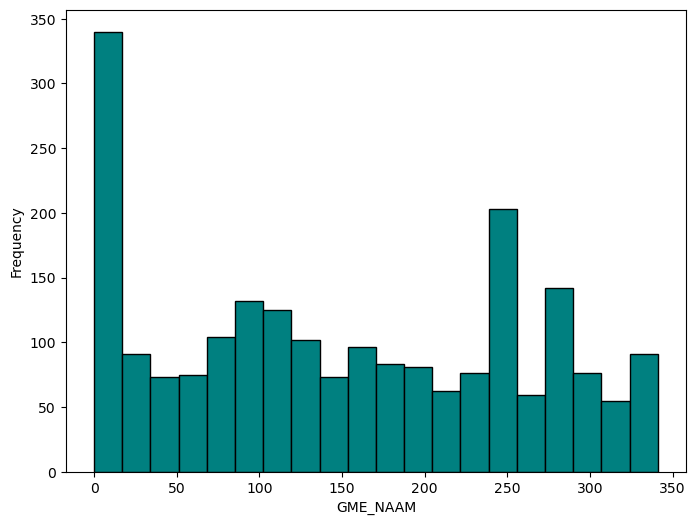

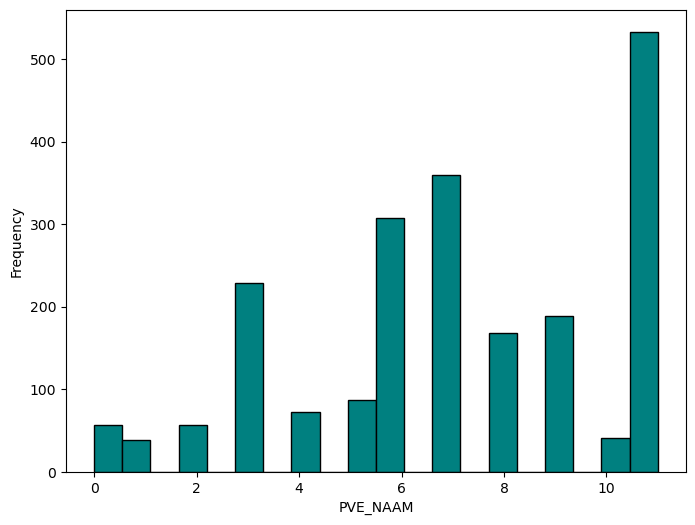

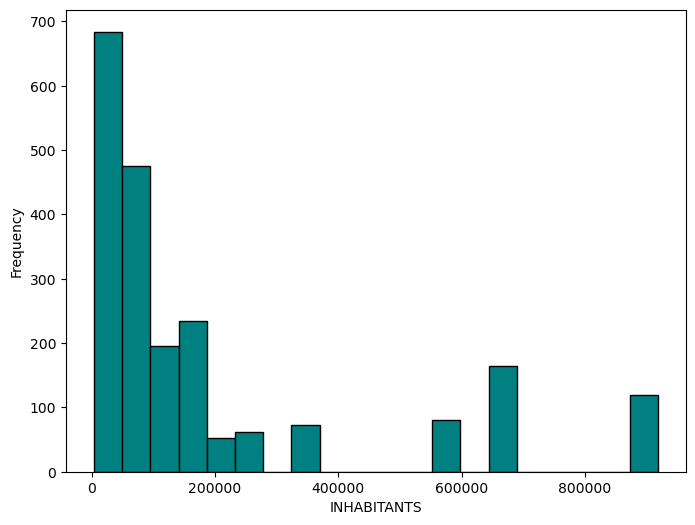

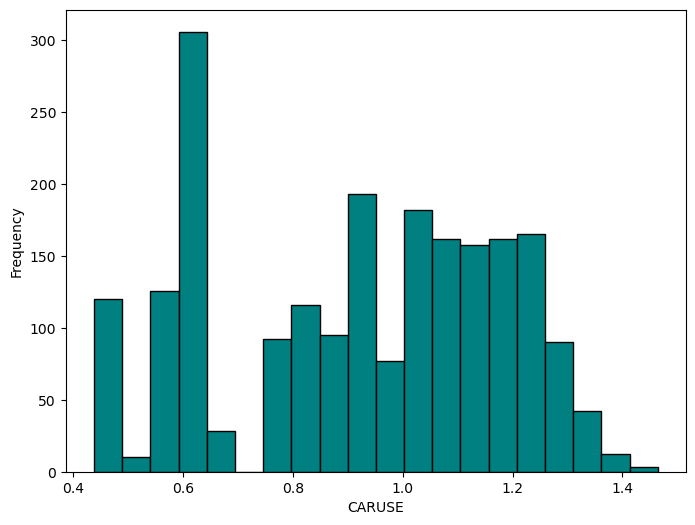

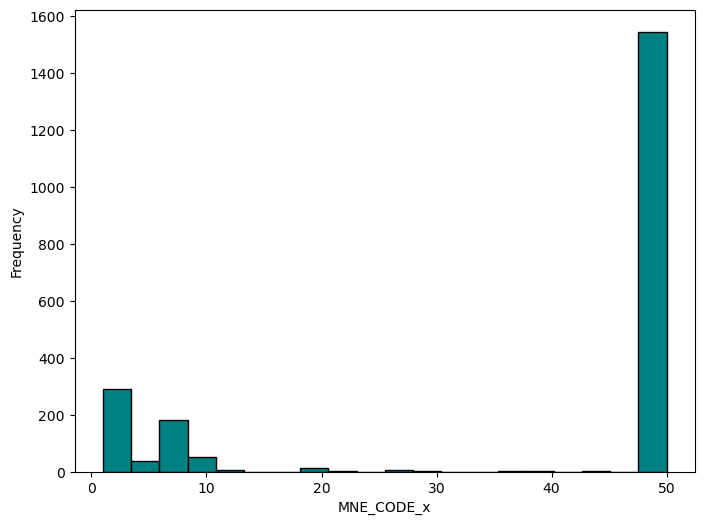

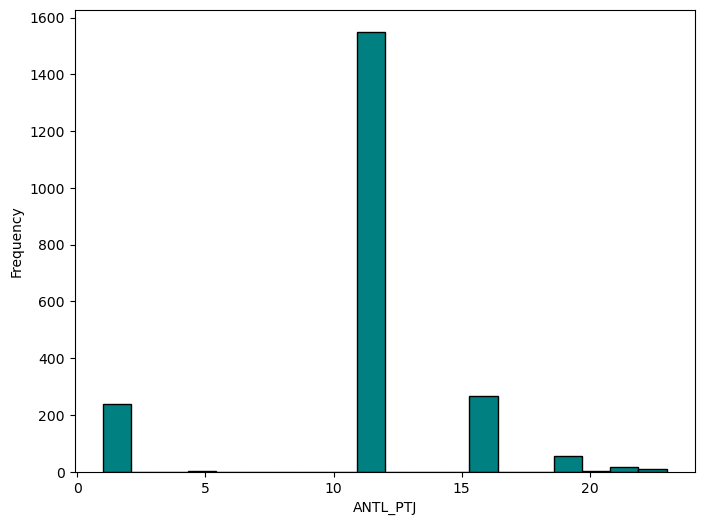

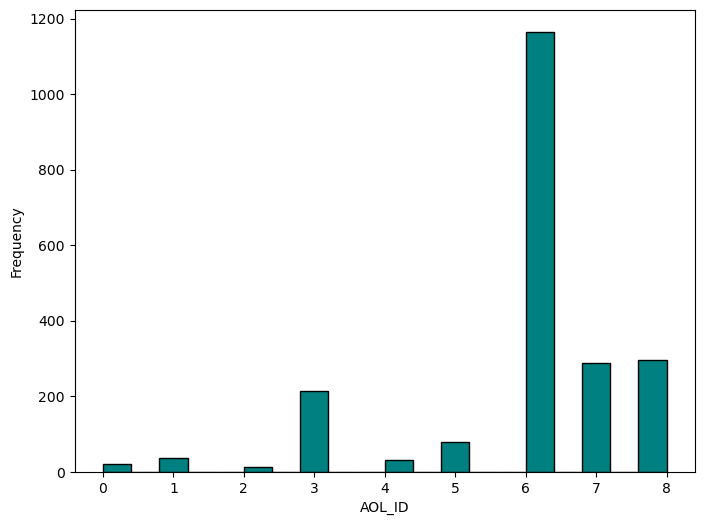

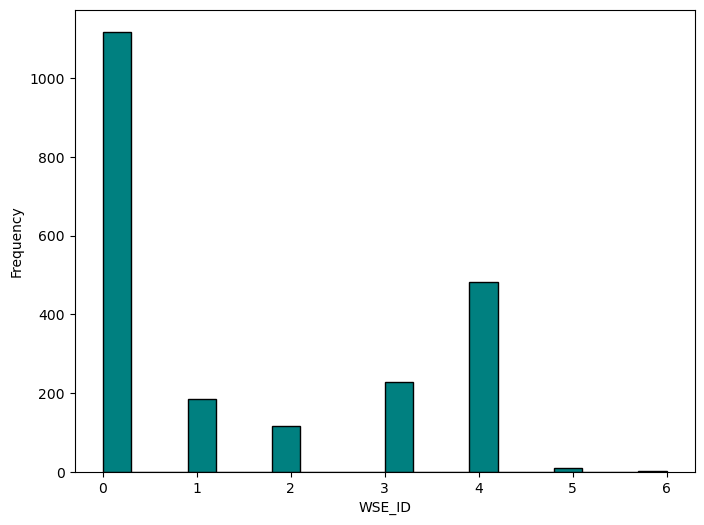

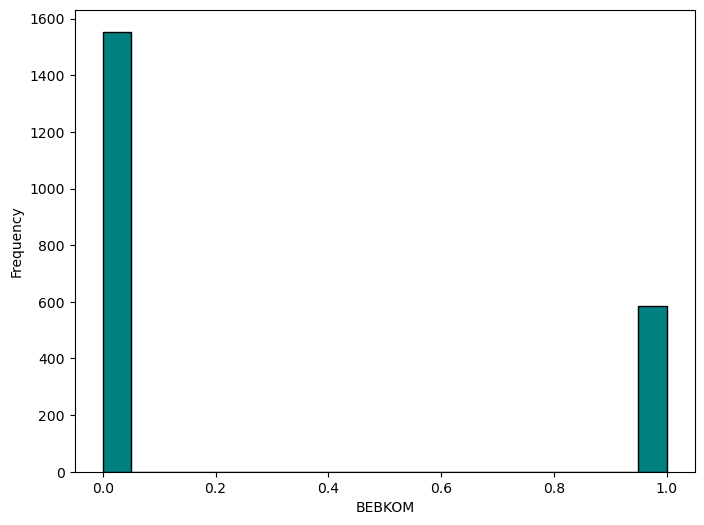

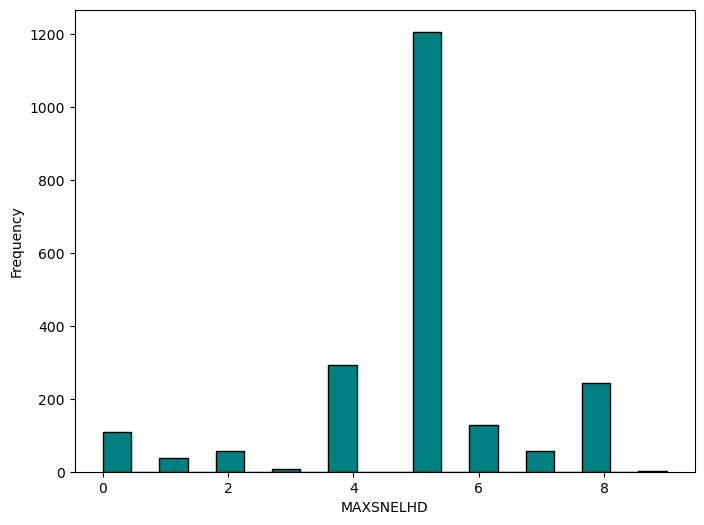

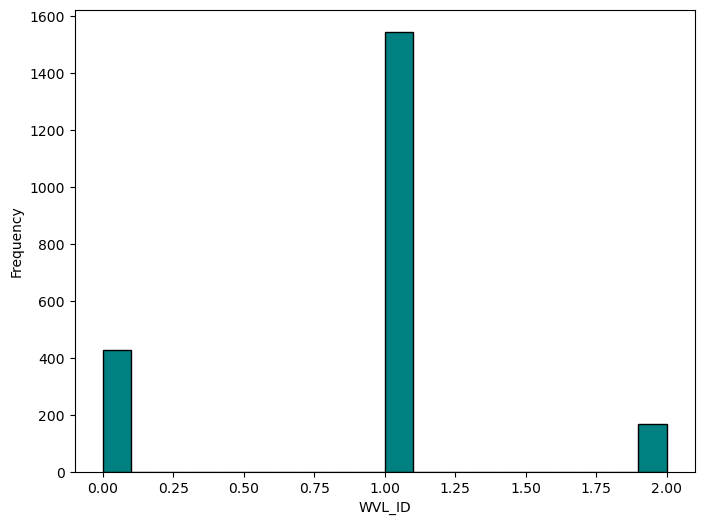

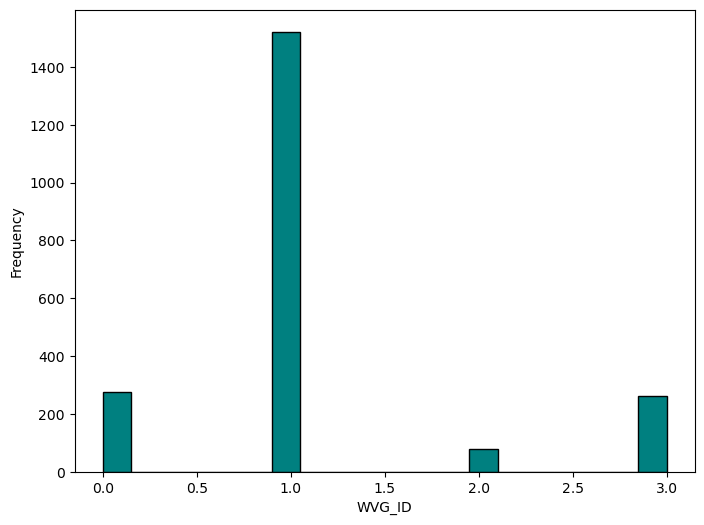

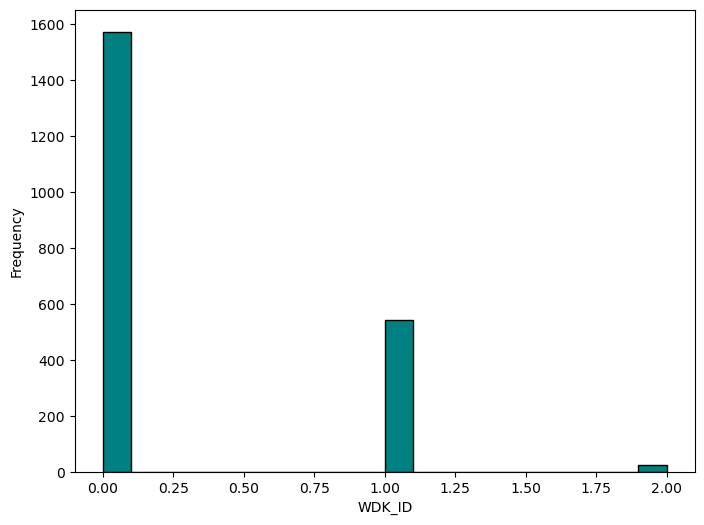

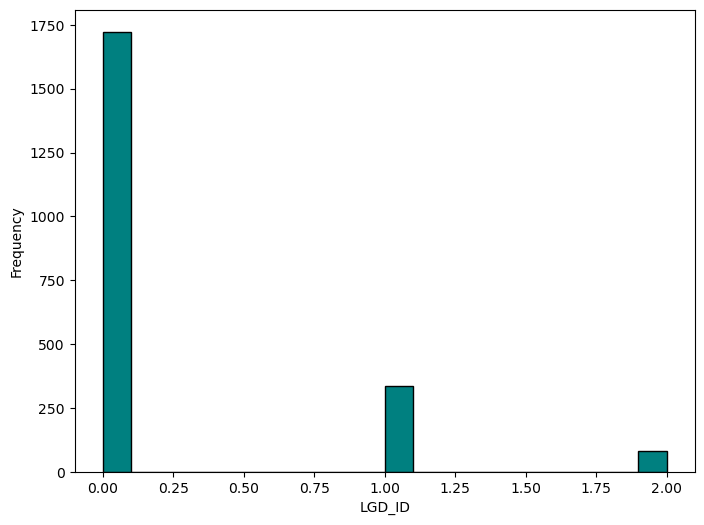

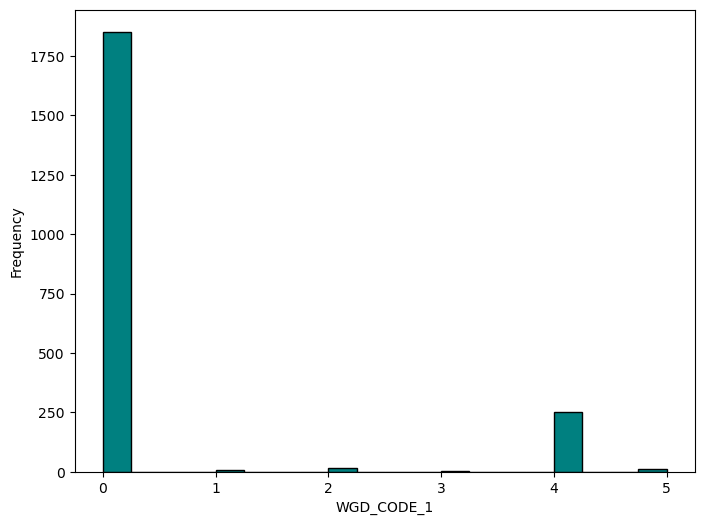

In [83]:
misclass = pd.DataFrame(X_test, columns=X.columns)
misclass['Actual_VICTIMS'] = y_test
misclass['Predicted_VICTIMS'] = y_test_pred
misclass['Misclass'] = abs(misclass['Actual_VICTIMS'] - misclass['Predicted_VICTIMS'])
misclass = misclass[misclass['Misclass'] == 1]

for column in misclass.columns:
    if column not in ['Actual_VICTIMS', 'Predicted_VICTIMS', 'Misclass']:
        plt.figure(figsize=(8, 6))
        misclass[column].plot(kind='hist', bins=20, edgecolor='black', color = 'teal')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()